# Notebook 4: Advanced Feature Importance Analysis

**Objectives:**
- Implement Permutation Importance for robust feature ranking
- Compare with XGBoost's built-in feature importance
- Provide framework for SHAP analysis (requires manual installation)
- Identify most influential features across methods

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
import sys
import os
sys.path.append(os.path.abspath('../src'))
from utils import load_data, get_xgb_model
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Try to import SHAP (optional)
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP library loaded successfully")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP library not available. Install with: python -m pip install shap")
    print("Continuing with Permutation Importance only...")

print("\nLibraries imported successfully!")

SHAP library loaded successfully

Libraries imported successfully!


## 2. Load Data and Model

In [2]:
# Load preprocessed data using utility function
df_encoded = load_data("../results/data/preprocessed_alerts.csv")

print(f"Dataset shape: {df_encoded.shape}")
print(f"\nFeatures: {df_encoded.shape[1] - 1}")
print(f"Samples: {df_encoded.shape[0]}")

Dataset shape: (17989, 19)

Features: 18
Samples: 17989


In [3]:
# Split features and target
X = df_encoded.drop('single_alert_is_regression', axis=1)
y = df_encoded['single_alert_is_regression'].astype(int)

# Create train/test split (same as training notebook)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (12592, 18)
Validation set: (2698, 18)
Test set: (2699, 18)


In [4]:
# Train a fresh XGBoost model for analysis using utility function
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = get_xgb_model(scale_pos_weight)

print("Training XGBoost model for feature importance analysis...")
model.fit(X_train, y_train)
print("Model training complete!")

Training XGBoost model for feature importance analysis...


Model training complete!


## 3. Method 1: Built-in XGBoost Feature Importance

Top 15 Features - Built-in Importance (Gain):


,Feature,Importance
0,single_alert_amount_abs,0.890191
1,"single_alert_series_signature_tags_fission, we...",0.054929
2,single_alert_series_signature_tags_webrender,0.019797
3,single_alert_new_value,0.009578
4,single_alert_series_signature_suite_freq,0.008314
5,alert_summary_status,0.004398
6,single_alert_status,0.003971
7,single_alert_amount_pct,0.003558
8,single_alert_prev_value,0.002559
9,single_alert_t_value,0.002557


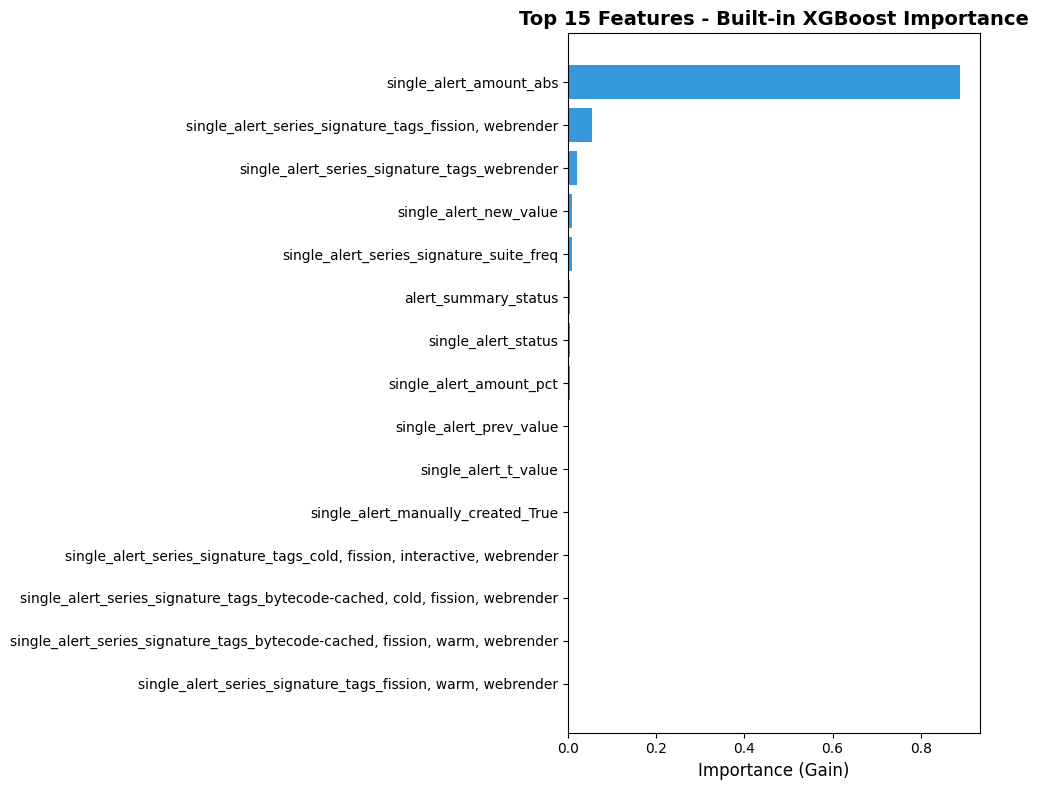

In [5]:
# Get built-in feature importance (gain-based)
builtin_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print("Top 15 Features - Built-in Importance (Gain):")
print("=" * 60)
display(builtin_importance.head(15))

# Visualize
plt.figure(figsize=(10, 8))
top_15 = builtin_importance.head(15)
plt.barh(range(len(top_15)), top_15['Importance'], color='#3498db')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title('Top 15 Features - Built-in XGBoost Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/builtin_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Method 2: Permutation Importance

In [6]:
print("Calculating Permutation Importance on test set...")
print("This may take a few minutes...\n")

# Calculate permutation importance
perm_importance = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,  # Number of times to permute each feature
    random_state=42,
    scoring='f1',
    n_jobs=-1  # Use all cores
)

# Create dataframe
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False).reset_index(drop=True)

print("Permutation Importance calculation complete!")
print("\nTop 15 Features - Permutation Importance:")
print("=" * 60)
display(perm_importance_df.head(15))

Calculating Permutation Importance on test set...
This may take a few minutes...



Permutation Importance calculation complete!

Top 15 Features - Permutation Importance:


,Feature,Importance_Mean,Importance_Std
0,single_alert_amount_abs,0.577003,0.012874
1,"single_alert_series_signature_tags_fission, we...",0.007224,0.001205
2,single_alert_series_signature_suite_freq,0.005646,0.000791
3,single_alert_new_value,0.005192,0.000532
4,alert_summary_status,0.001665,0.000700
5,single_alert_prev_value,0.000743,0.000200
6,single_alert_series_signature_tags_webrender,0.000484,0.000131
7,single_alert_amount_pct,0.000438,0.000588
8,single_alert_t_value,0.000351,0.000263
9,single_alert_status,0.000000,0.000000


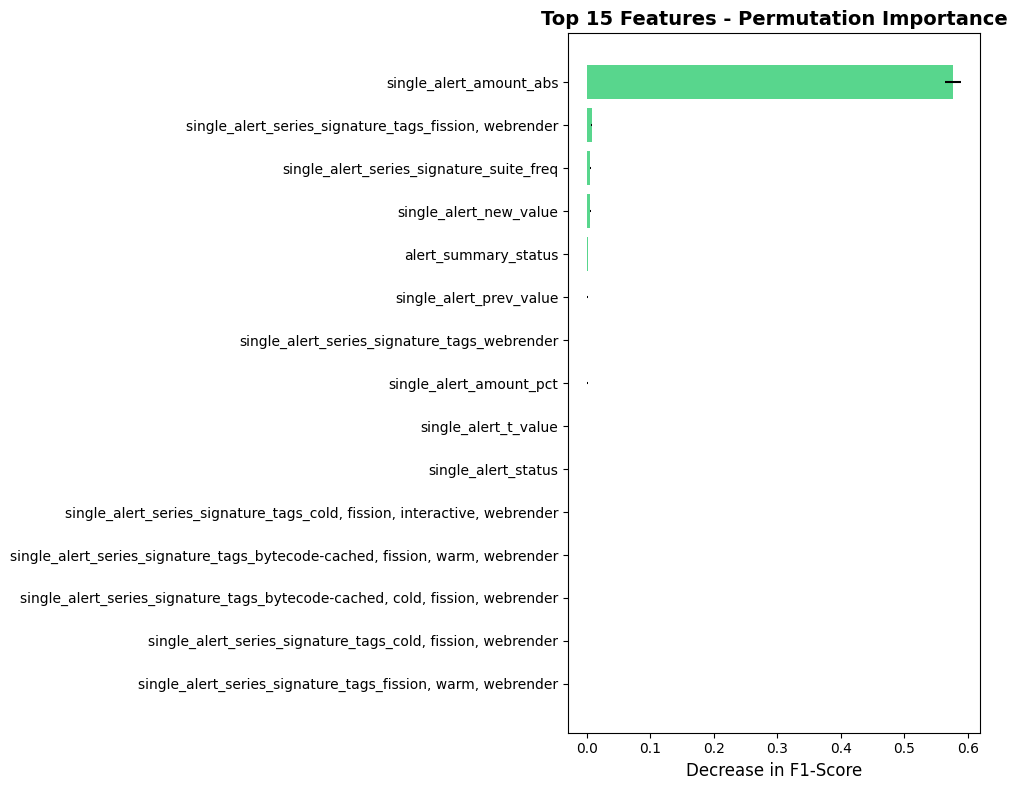

In [7]:
# Visualize Permutation Importance with error bars
plt.figure(figsize=(10, 8))
top_15_perm = perm_importance_df.head(15)
plt.barh(range(len(top_15_perm)), top_15_perm['Importance_Mean'], 
         xerr=top_15_perm['Importance_Std'], color='#2ecc71', alpha=0.8)
plt.yticks(range(len(top_15_perm)), top_15_perm['Feature'])
plt.xlabel('Decrease in F1-Score', fontsize=12)
plt.title('Top 15 Features - Permutation Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Method 3: SHAP Analysis (if available)

Calculating SHAP values...
This may take several minutes...

SHAP values calculated!


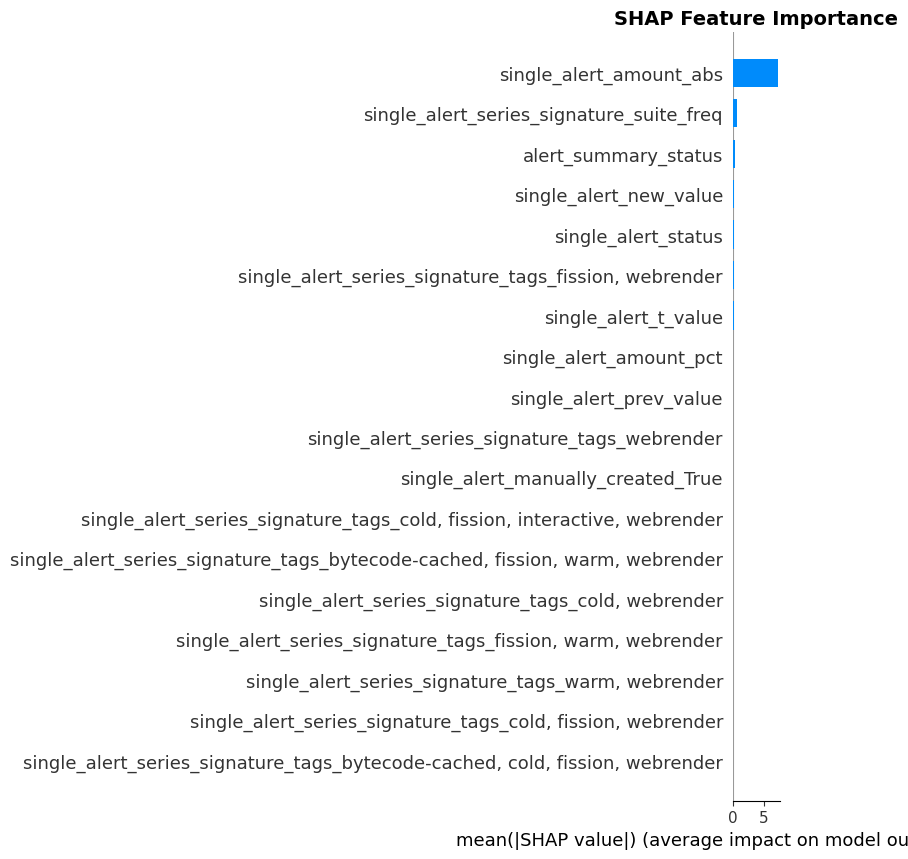

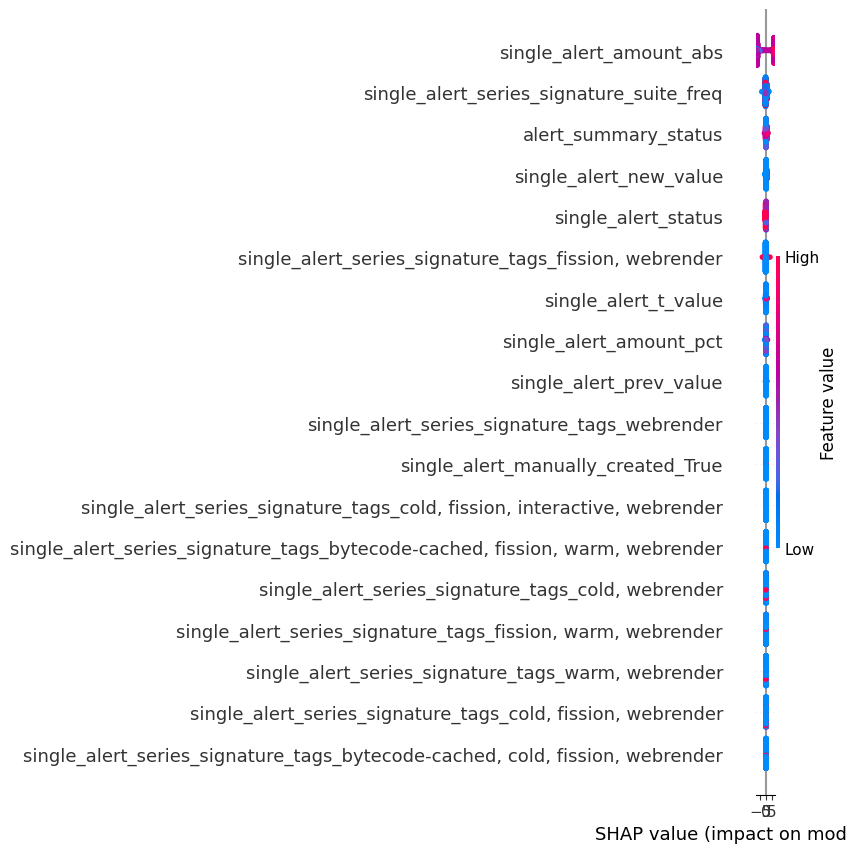


Top 15 Features - SHAP Importance:


,Feature,Importance
0,single_alert_amount_abs,7.272997
1,single_alert_series_signature_suite_freq,0.620674
2,alert_summary_status,0.301078
3,single_alert_new_value,0.262858
4,single_alert_status,0.246355
5,"single_alert_series_signature_tags_fission, we...",0.223691
6,single_alert_t_value,0.138371
7,single_alert_amount_pct,0.076982
8,single_alert_prev_value,0.043938
9,single_alert_series_signature_tags_webrender,0.010915


In [8]:
if SHAP_AVAILABLE:
    print("Calculating SHAP values...")
    print("This may take several minutes...\n")
    
    # Use TreeExplainer for XGBoost - much faster than other explainers
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values on a sample of test data (for speed)
    sample_size = min(1000, len(X_test))
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
    
    shap_values = explainer.shap_values(X_test_sample)
    
    print("SHAP values calculated!")
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../results/figures/shap_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Detailed summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('../results/figures/shap_summary_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Get SHAP importance as dataframe
    shap_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("\nTop 15 Features - SHAP Importance:")
    print("=" * 60)
    display(shap_importance_df.head(15))
    
else:
    print("SHAP library not available.")
    print("\nTo install SHAP:")
    print("  python -m pip install shap")
    print("\nThen re-run this notebook to see SHAP analysis.")
    shap_importance_df = None

## 6. Comparison of Methods

In [9]:
# Compare top 10 features across methods
top_10_builtin = set(builtin_importance.head(10)['Feature'])
top_10_perm = set(perm_importance_df.head(10)['Feature'])

print("Comparison of Top 10 Features Across Methods")
print("=" * 60)
print("\nBuilt-in Importance:", list(builtin_importance.head(10)['Feature']))
print("\nPermutation Importance:", list(perm_importance_df.head(10)['Feature']))

if SHAP_AVAILABLE and shap_importance_df is not None:
    top_10_shap = set(shap_importance_df.head(10)['Feature'])
    print("\nSHAP Importance:", list(shap_importance_df.head(10)['Feature']))
    
    # Features appearing in all methods
    common_all = top_10_builtin & top_10_perm & top_10_shap
    print(f"\nFeatures in top 10 of ALL methods ({len(common_all)}):")
    print(list(common_all))
else:
    # Features appearing in both available methods
    common_both = top_10_builtin & top_10_perm
    print(f"\nFeatures in top 10 of BOTH methods ({len(common_both)}):")
    print(list(common_both))

Comparison of Top 10 Features Across Methods

Built-in Importance: ['single_alert_amount_abs', 'single_alert_series_signature_tags_fission, webrender', 'single_alert_series_signature_tags_webrender', 'single_alert_new_value', 'single_alert_series_signature_suite_freq', 'alert_summary_status', 'single_alert_status', 'single_alert_amount_pct', 'single_alert_prev_value', 'single_alert_t_value']

Permutation Importance: ['single_alert_amount_abs', 'single_alert_series_signature_tags_fission, webrender', 'single_alert_series_signature_suite_freq', 'single_alert_new_value', 'alert_summary_status', 'single_alert_prev_value', 'single_alert_series_signature_tags_webrender', 'single_alert_amount_pct', 'single_alert_t_value', 'single_alert_status']

SHAP Importance: ['single_alert_amount_abs', 'single_alert_series_signature_suite_freq', 'alert_summary_status', 'single_alert_new_value', 'single_alert_status', 'single_alert_series_signature_tags_fission, webrender', 'single_alert_t_value', 'single_

In [10]:
# Create unified comparison table
comparison_df = builtin_importance[['Feature', 'Importance']].rename(
    columns={'Importance': 'Builtin_Importance'}
).merge(
    perm_importance_df[['Feature', 'Importance_Mean']].rename(
        columns={'Importance_Mean': 'Perm_Importance'}
    ), on='Feature', how='outer'
)

if SHAP_AVAILABLE and shap_importance_df is not None:
    comparison_df = comparison_df.merge(
        shap_importance_df[['Feature', 'Importance']].rename(
            columns={'Importance': 'SHAP_Importance'}
        ), on='Feature', how='outer'
    )

# Add rankings
comparison_df['Builtin_Rank'] = comparison_df['Builtin_Importance'].rank(ascending=False)
comparison_df['Perm_Rank'] = comparison_df['Perm_Importance'].rank(ascending=False)

if SHAP_AVAILABLE and shap_importance_df is not None:
    comparison_df['SHAP_Rank'] = comparison_df['SHAP_Importance'].rank(ascending=False)
    comparison_df['Avg_Rank'] = comparison_df[['Builtin_Rank', 'Perm_Rank', 'SHAP_Rank']].mean(axis=1)
else:
    comparison_df['Avg_Rank'] = comparison_df[['Builtin_Rank', 'Perm_Rank']].mean(axis=1)

comparison_df = comparison_df.sort_values('Avg_Rank').reset_index(drop=True)

print("\nTop 15 Features - Unified Ranking:")
print("=" * 60)
display(comparison_df.head(15))

# Save to CSV
comparison_df.to_csv('../results/metrics/feature_importance_comparison.csv', index=False)
print("\nComparison saved to: results/feature_importance_comparison.csv")


Top 15 Features - Unified Ranking:


,Feature,Builtin_Importance,Perm_Importance,SHAP_Importance,Builtin_Rank,Perm_Rank,SHAP_Rank,Avg_Rank
0,single_alert_amount_abs,0.890191,0.577003,7.272997,1.0,1.0,1.0,1.000000
1,single_alert_series_signature_suite_freq,0.008314,0.005646,0.620674,5.0,3.0,2.0,3.333333
2,"single_alert_series_signature_tags_fission, we...",0.054929,0.007224,0.223691,2.0,2.0,6.0,3.333333
3,single_alert_new_value,0.009578,0.005192,0.262858,4.0,4.0,4.0,4.000000
4,alert_summary_status,0.004398,0.001665,0.301078,6.0,5.0,3.0,4.666667
5,single_alert_series_signature_tags_webrender,0.019797,0.000484,0.010915,3.0,7.0,10.0,6.666667
6,single_alert_prev_value,0.002559,0.000743,0.043938,9.0,6.0,9.0,8.000000
7,single_alert_amount_pct,0.003558,0.000438,0.076982,8.0,8.0,8.0,8.000000
8,single_alert_t_value,0.002557,0.000351,0.138371,10.0,9.0,7.0,8.666667
9,single_alert_status,0.003971,0.000000,0.246355,7.0,14.0,5.0,8.666667



Comparison saved to: results/feature_importance_comparison.csv


## 7. Feature Categorization

Top 15 Features by Category:


,Feature,Category,Avg_Rank
0,single_alert_amount_abs,Magnitude,1.000000
1,single_alert_series_signature_suite_freq,Context,3.333333
2,"single_alert_series_signature_tags_fission, we...",Other,3.333333
3,single_alert_new_value,Magnitude,4.000000
4,alert_summary_status,Workflow,4.666667
5,single_alert_series_signature_tags_webrender,Other,6.666667
6,single_alert_prev_value,Magnitude,8.000000
7,single_alert_amount_pct,Magnitude,8.000000
8,single_alert_t_value,Magnitude,8.666667
9,single_alert_status,Workflow,8.666667



Feature Category Distribution (Top 15):
Category
Other        6
Magnitude    5
Workflow     3
Context      1
Name: count, dtype: int64


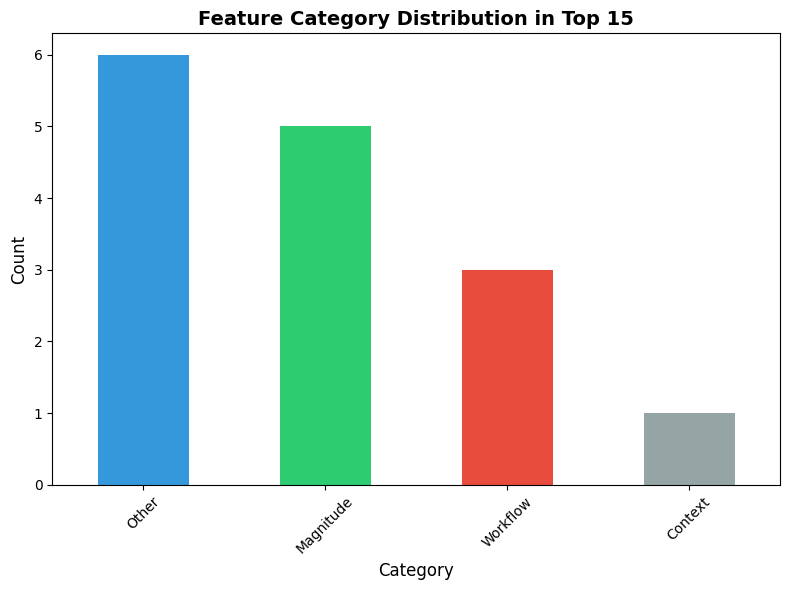

In [11]:
# Categorize top features
magnitude_keywords = ['amount', 'pct', 'abs', 't_value', 'prev_value', 'new_value']
context_keywords = ['repository', 'framework', 'platform', 'suite']
workflow_keywords = ['status', 'manually']

def categorize_feature(feature_name):
    feature_lower = feature_name.lower()
    if any(kw in feature_lower for kw in magnitude_keywords):
        return 'Magnitude'
    elif any(kw in feature_lower for kw in context_keywords):
        return 'Context'
    elif any(kw in feature_lower for kw in workflow_keywords):
        return 'Workflow'
    else:
        return 'Other'

# Apply categorization to top 15
top_15_unified = comparison_df.head(15).copy()
top_15_unified['Category'] = top_15_unified['Feature'].apply(categorize_feature)

print("Top 15 Features by Category:")
print("=" * 60)
display(top_15_unified[['Feature', 'Category', 'Avg_Rank']])

# Count by category
category_counts = top_15_unified['Category'].value_counts()
print("\nFeature Category Distribution (Top 15):")
print(category_counts)

# Visualize
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c', '#95a5a6'])
plt.title('Feature Category Distribution in Top 15', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/figures/feature_categories.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Key Findings

In [12]:
print("KEY FINDINGS")
print("=" * 70)

print("\n1. Most Consistent Important Features:")
print("   (appearing in top 10 of multiple methods)")
if SHAP_AVAILABLE and shap_importance_df is not None:
    common = top_10_builtin & top_10_perm & top_10_shap
else:
    common = top_10_builtin & top_10_perm
for feat in list(common)[:5]:
    print(f"   - {feat}")

print("\n2. Feature Category Analysis:")
for cat, count in category_counts.items():
    pct = (count / 15) * 100
    print(f"   - {cat}: {count} features ({pct:.1f}% of top 15)")

print("\n3. Method Agreement:")
if SHAP_AVAILABLE and shap_importance_df is not None:
    agreement = len(common) / 10 * 100
    print(f"   - {agreement:.0f}% of top 10 features agree across all 3 methods")
else:
    agreement = len(common_both) / 10 * 100
    print(f"   - {agreement:.0f}% of top 10 features agree across both methods")

print("\n" + "=" * 70)

KEY FINDINGS

1. Most Consistent Important Features:
   (appearing in top 10 of multiple methods)
   - single_alert_new_value
   - single_alert_status
   - single_alert_series_signature_tags_fission, webrender
   - single_alert_amount_abs
   - single_alert_series_signature_suite_freq

2. Feature Category Analysis:
   - Other: 6 features (40.0% of top 15)
   - Magnitude: 5 features (33.3% of top 15)
   - Workflow: 3 features (20.0% of top 15)
   - Context: 1 features (6.7% of top 15)

3. Method Agreement:
   - 100% of top 10 features agree across all 3 methods



## 9. Save Results

In [13]:
# Save individual importance dataframes
builtin_importance.to_csv('../results/metrics/builtin_importance.csv', index=False)
perm_importance_df.to_csv('../results/metrics/permutation_importance.csv', index=False)

if SHAP_AVAILABLE and shap_importance_df is not None:
    shap_importance_df.to_csv('../results/metrics/shap_importance.csv', index=False)

print("All results saved to results/ directory")
print("\nNotebook complete!")

All results saved to results/ directory



Notebook complete!
